In [6]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import numpy as np

from computage.utils.data_utils import cond2class
from computage.plots.benchplots import plot_class_bench, plot_medae, plot_bias

plt.rcParams["font.family"] = ["DejaVu Sans"]
plt.rcParams["savefig.bbox"] = "tight"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Main figures - benchmarking

In [10]:
data = pd.read_csv('/home/dkriukov/ComputAge/tmp_bench_results/prefinal1_bench_pvals.csv', 
                   index_col=0) #< 0.05
# data = pd.read_csv('/home/dkriukov/ComputAge/tmp_bench_results/prefinal0_bench_adj_pvals.csv', index_col=0)
# data = pd.read_csv('/home/dkriukov/ComputAge/tmp_bench_results/prefinal0_bench_bools.csv', index_col=0)
AA2data = data.filter(regex='AA2')
AA1data = data.filter(regex='AA1')

from statsmodels.stats.multitest import multipletests
def correction(x):
        return multipletests(x, method='fdr_bh')[1] 
AA2data = AA2data.dropna(axis=1).apply(correction, axis=0) < 0.05
AA1data = AA1data.dropna(axis=1).apply(correction, axis=0) < 0.05

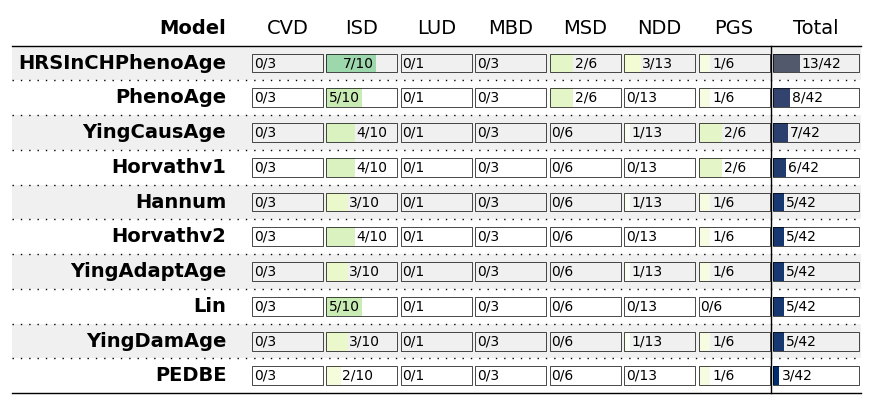

In [11]:
ax = plot_class_bench(AA2data, 
                      figsize = (11.0, 5), 
                      firstcolwidth = 3.2)
plt.savefig('figures/main/AA2_main.pdf', format='pdf', dpi=180)
plt.show()

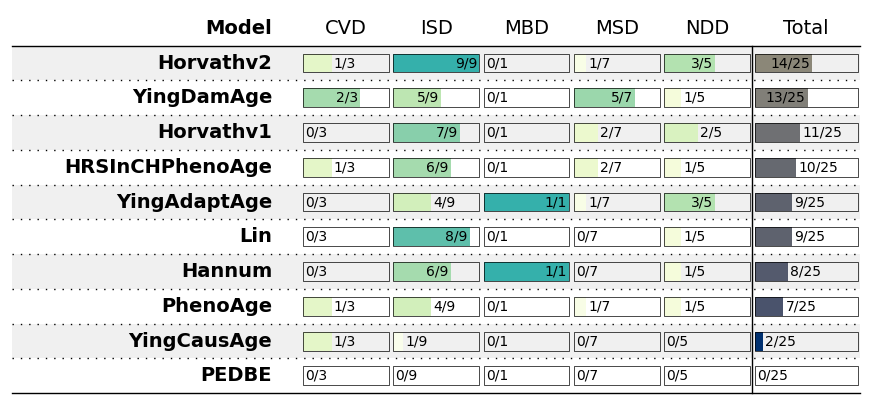

In [12]:
ax = plot_class_bench(AA1data,
                        figsize = (11.0, 5), 
                        firstcolwidth = 3.2)
plt.savefig('figures/main/AA1_main.pdf', format='pdf', dpi=180)
plt.show()

# Chronological age prediction accuracy

/home/dkriukov/ComputAge/computage/plots/benchplots.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=result, x='index', y='MAE', orient='v', ax=axes, palette=color_iters, zorder=100, )
/home/dkriukov/ComputAge/computage/plots/benchplots.py:130: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')


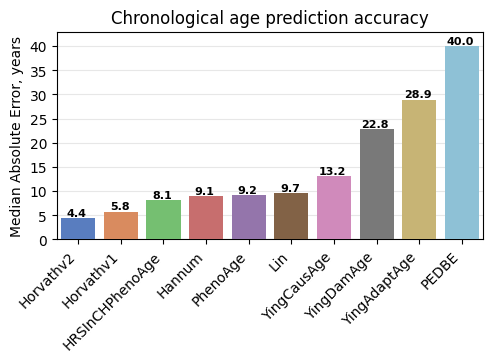

In [13]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.colors as color
from scipy.stats import norm
import pandas as pd

result = pd.read_csv('tmp_bench_results/prefinal1_bench_CA_pred_MAE.csv', index_col=0)

ax = plot_medae(result, figsize=(5.5, 2.7))
plt.savefig('figures/main/CA_main.pdf', format='pdf', dpi=180)
plt.show()

# Chronological age prediction bias

/home/dkriukov/ComputAge/computage/plots/benchplots.py:155: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

/home/dkriukov/ComputAge/computage/plots/benchplots.py:159: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


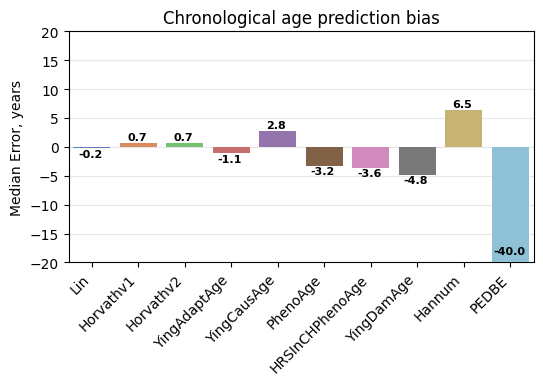

In [14]:
result = pd.read_csv('tmp_bench_results/prefinal1_bench_CA_pred_bias.csv', index_col=0)

ax = plot_bias(result, figsize=(5.5, 2.7))
plt.savefig('figures/main/AA_bias_main.pdf', format='pdf', dpi=180)
plt.show()

# Legacy plot_bench

In [44]:
# df = pd.melt(AA2data.reset_index(), id_vars=['index'])
# df['Condition'] = [c.split(':')[1] for c in df['variable']]
# df['Class'] = cond2class(df['Condition'])
# df = df.drop(['variable', 'Condition'], axis=1)

# sums = df.groupby(['index', 'Class']).sum()
# counts = df.groupby(['index', 'Class']).count()
# sums = pd.pivot(sums.reset_index(), index='index', columns=['Class'], values='value')
# counts = pd.pivot(counts.reset_index(), index='index', columns=['Class'], values='value')
# sums['Total'] = sums.sum(axis=1)
# counts['Total'] = counts.sum(axis=1)
# classcounts = counts.iloc[0]
# vals = sums / counts
# vals.index.name = 'Model'
# vals = vals.sort_values('Total', ascending=False)

In [16]:
# cmap = LinearSegmentedColormap.from_list(
#     name="bugw", colors=["#ffffff", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=256
# )

# def form(base):
#     def formatter(x):
#         return f'{str(int(round(x * base)))}/{base}'
#     return formatter

# col_defs = []
# for col in vals.columns[:-1]:
#     base = classcounts[col]
#     cldef = ColumnDefinition(
#                     col,
#                     width=1.0,
#                     plot_fn=bar,
#                     textprops={"ha": "center"},
#                     plot_kw={
#                         "cmap": cmap,
#                         "plot_bg_bar": True,
#                         "annotate": True,
#                         "height": 0.9,
#                         "lw": 0.5,
#                         "formatter": form(base) #apply_formatter()
#                         },
#                     )
#     col_defs.append(cldef)

# col_defs = col_defs + [
#     ColumnDefinition(
#                     'Total',
#                     width=1.2,
#                     plot_fn=bar,
#                     border="left",
#                     textprops={"ha": "center"},
#                     plot_kw={
#                         "cmap": cividis,
#                         "plot_bg_bar": True,
#                         "annotate": True,
#                         "height": 0.9,
#                         "lw": 0.5,
#                         "formatter": form(classcounts['Total']) 
#                         },
#                     ),
#         ColumnDefinition(
#             name="Model",
#             textprops={"ha": "right", "weight": "bold"},
#             width=4.1,
#         )
#     ]

In [46]:
# plt.rcParams["font.family"] = ["DejaVu Sans"]
# plt.rcParams["savefig.bbox"] = "tight"

# fig, ax = plt.subplots(figsize=(12.5, 7))

# table = Table(
#     vals.head(10),
#     column_definitions=col_defs,
#     row_dividers=True,
#     footer_divider=True,
#     odd_row_color="#ffffff", 
#     even_row_color="#f0f0f0",
#     ax=ax,
#     textprops={"fontsize": 14},
#     row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
#     col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
#     column_border_kw={"linewidth": 1, "linestyle": "-"},
# )

# Supplementary figures

In [32]:
test = pd.read_csv('/home/dkriukov/ComputAge/tmp_bench_results/prefinal0_bench_adj_pvals.csv', index_col=0)

test.head(3)

,GSE56046:AS:AA2,GSE56581:AS:AA2,GSE107143:AS:AA2,GSE32148:IBD:AA2,GSE87640:IBD:AA2,GSE87648:IBD:AA2,GSE67705:HIV:AA2,GSE67751:HIV:AA2,GSE77696:HIV:AA2,GSE143942:HIV:AA2,...,GSE138653:RA:AA1,GSE176168:RA:AA1,GSE228104:RA:AA1,GSE62003:T2D:AA1,GSE43976:MS:AA1,GSE103929:MS:AA1,GSE103929:OBS:AA1,GSE112596:MS:AA1,GSE130491:MS:AA1,GSE151355:PD:AA1
Horvathv1,0.999994,0.999994,0.999994,0.652857,0.652857,0.652857,9.621312e-09,0.000201,1.087367e-09,0.404086,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hannum,0.999940,0.999940,0.999940,0.824776,0.137436,0.032794,2.976399e-06,0.069390,7.005687e-01,0.522219,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lin,0.970171,0.996613,0.841088,0.908947,0.046172,0.359504,5.907741e-09,0.000022,6.281147e-12,0.037791,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
#AAP
aap = test.filter(regex='AA2')


data = aap.copy()
data = data.where(data < 0.05)
data = -np.log10(data) 
total = np.isfinite(data).sum(1).sort_values(ascending=False)
sorted_indices = total.index
data = data[data.columns.sort_values()]
data['Total'] = total
data = data.loc[sorted_indices].iloc[:16]


groups = [s.split(':')[1] for s in data.columns[:-1]] #tmp, need to be changed with disease classes
group_colors = {g:c for g,c in zip(np.unique(groups), sns.color_palette('Set3'))}

In [40]:
group_colors

{'AD': (0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
 'AS': (1.0, 1.0, 0.7019607843137254),
 'CGL': (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
 'CJD': (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
 'COPD': (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
 'HGPS': (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
 'HIV': (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
 'HIV_TB': (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
 'IBD': (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
 'MCI': (0.7372549019607844, 0.5019607843137255, 0.7411764705882353),
 'MDPS': (0.8, 0.9215686274509803, 0.7725490196078432),
 'MS': (1.0, 0.9294117647058824, 0.43529411764705883)}

KeyError: 'PD'

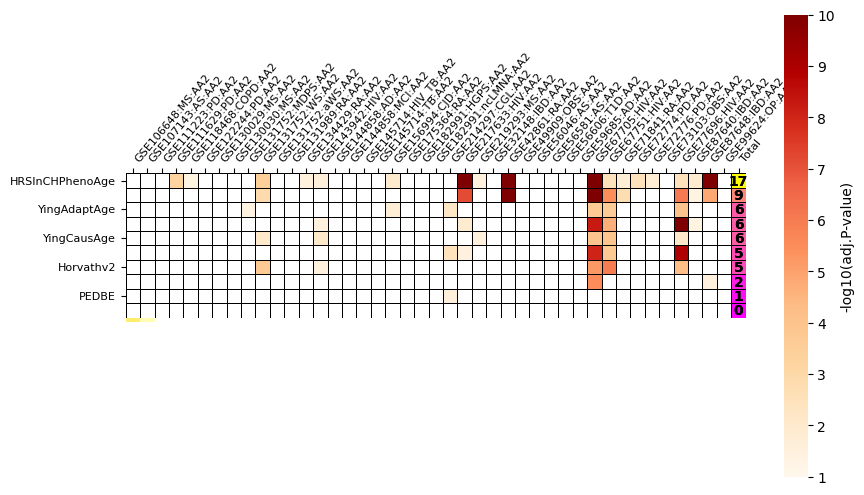

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the main heatmap
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharey=True)
ax = sns.heatmap(data, square=True, cmap='OrRd',
                 cbar_kws={'label': '-log10(adj.P-value)'},
                 vmin=1, vmax=10,
                 linecolor='k', 
                 linewidth=0.5, 
                 ax=axes, 
                 cbar=True
                 )

data2 = data.copy()
data2.iloc[:, :-1] = float('nan')
sns.heatmap(data2, annot=True, cmap="spring", cbar=False, ax=axes,
            linecolor='k', 
            linewidth=0.5, )

# Add annotations to the last column of the heatmap
for i in range(len(data.index)):
    ax.text(len(data.columns) - 0.5, i + 0.5, str(data.iloc[i, -1]),
            ha='center', va='center', color='k', fontsize=8)

# Change colors of the cells in the last column
for text in ax.texts:
    text.set_color('k')
    text.set_fontweight('bold')
    text.set_fontsize(10)

# Customize x-axis ticks
ax.xaxis.tick_top()  # x axis on top
ax.xaxis.set_label_position('top')
ax.yaxis.set_tick_params(colors='k')
ax.xaxis.set_tick_params(rotation=50, colors='k')
ax.set_xticklabels(ax.get_xticklabels(), ha='left', fontsize=8, color='k')
ax.set_yticklabels(ax.get_yticklabels(), ha='right', fontsize=8, color='k')


for i, cond in enumerate(data.columns[:-1]):
    cond = cond.split(":")[1]
    color = group_colors[cond]
    ax.add_patch(plt.Rectangle(xy=(i, -0.03), height=0.03, width=1, color=color, lw=0,
                               transform=ax.get_xaxis_transform(), clip_on=False))

axes.collections[0].cmap.set_bad('0.65')
plt.tight_layout()
plt.show()